In [2]:
!nvidia-smi

Tue Jul  6 09:11:09 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.118.02   Driver Version: 440.118.02   CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 108...  Off  | 00000000:05:00.0 Off |                  N/A |
| 28%   50C    P8    17W / 250W |     10MiB / 11178MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce GTX 108...  Off  | 00000000:06:00.0 Off |                  N/A |
| 49%   82C    P2   255W / 250W |   6611MiB / 11178MiB |    100%      Default |
+-------------------------------+----------------------+----------------------+
|   2  G

In [3]:
import os
import torch
import torch.nn as nn
import numpy as np
import time
import torch.optim as optim
import natsort
import bezier

from dataset import encoder
from model import get_pretrained_model
from dataset import jpg2np, get_loader
from torchvision import models
from bezier.hazmat.curve_helpers import evaluate_hodograph, get_curvature
from torch.utils.data import TensorDataset, DataLoader
from sklearn.decomposition import PCA

In [4]:
cut = 1000
upper, lower = 150, 10000
GPU_NUM = 3
bs=10
datastyle = 'elementwise'
device = torch.device(f'cuda:{GPU_NUM}' if torch.cuda.is_available() else 'cpu')
torch.cuda.set_device(device) # change allocation of current GPU
print('Current cuda device ', torch.cuda.current_device())

Current cuda device  3


# Embedding -> PCA -> Bezier -> Curvature

In [5]:
## Load vgg16 embedding data ##
video_names = []
embeddings = []
labels = []
for embedding in os.listdir('./ucf_embeddings'):
    if embedding == '.ipynb_checkpoints': continue
    loc1 = embedding.find('_')
    loc2 = loc1 + embedding[loc1+1:].find('_')
    labels.append(embedding[loc1+1:loc2+1])
    video_names.append(embedding[:-4])
  

    embeddings.append(np.load('./ucf_embeddings/{}'.format(embedding)))


y, _ = encoder(labels)

embeddings = np.stack(embeddings)
embeddings_pca = embeddings.reshape(embeddings.shape[0]*embeddings.shape[1],-1)

## PCA ##
pca = PCA(3)
embeddings_pca = pca.fit_transform(embeddings_pca).reshape(embeddings.shape[0], embeddings.shape[1],-1)
embeddings_pca.shape

## Bezier Curve and Curvature ##
k = dict()
curves = []
for i, embedding in enumerate(embeddings_pca):
#     print(embedding.shape)
    curves.append(bezier.Curve.from_nodes(embedding.T))
    kappa = []
    for s in range(30):
        t = s / 30
        tangent_vec = curves[i].evaluate_hodograph(t)
        kappa.append(get_curvature(embedding.T, tangent_vec, t))
    k[video_names[i]] = kappa
    if i% 1000 == 0:
        print(i, len(embeddings_pca), 'PCA')

K = np.stack(list(k.values())) # [N, 30]
print("Curvature Shape", K.shape)

## Elementwise operation ##
result = list()
for video in range(len(embeddings)):
    elementwise = list()
    for frame in range(30):
        elementwise.append(embeddings[video][frame] * K[video][frame])        
    result.append(np.stack(elementwise))
    if (video+1) % 1000 == 0: 
        print("[%d / %d] video processing!" %(video, len(embeddings)))
result = torch.from_numpy(np.stack(result))
print(embeddings.shape, embeddings_pca.shape, K.shape, result.shape)

0 9812 PCA
1000 9812 PCA
2000 9812 PCA


KeyboardInterrupt: 

In [4]:
print(embeddings.shape, embeddings_pca.shape, K.shape, result.shape, len(curves))

(9812, 30, 512) (9812, 30, 3) (9812, 30) torch.Size([9812, 30, 512]) 9812


# Visualize

In [43]:
import matplotlib.pyplot as plt
def plot_bezier(curve,name, p=30):
    fig = plt.figure(figsize=(10,10))
    fig.suptitle(name)
    ax = fig.add_subplot(projection='3d')


    ## Embedding Points ##
    nodes = curve.nodes
    ax.scatter(
        nodes[0, :],    # z-coordinates.
        nodes[1, :],    # z-coordinates.
        nodes[2, :],    # z-coordinates.
        color='black'
    )
    for i in range(len(nodes[0])):
        ax.text(
            nodes[0, i],    # z-coordinates.
            nodes[1, i],    # z-coordinates.
            nodes[2, i],    # z-coordinates.
            '{}'.format(5*(i)+1)
        )

    ## Bezier Points ##
    ts = np.arange(0, 1, 1/p)
    curve_points = []
    for t in ts:
        curve_points.append(curve.evaluate(t).squeeze())
    

    curve_points = np.stack(curve_points).T

    ax.plot(
        curve_points[0, :],    # z-coordinates.
        curve_points[1, :],    # z-coordinates.
        curve_points[2, :],    # z-coordinates.
    )
    
    
#     plt.savefig('./plot/bezier/BezierCurve_{}.jpeg'.format(name))
    plt.savefig('./BezierCurve_{}.jpeg'.format(name))
    plt.show()
    plt.close()
    

In [44]:
video_names[0]

'v_PlayingDaf_g25_c04'

1 2375 v_Haircut_g12_c02


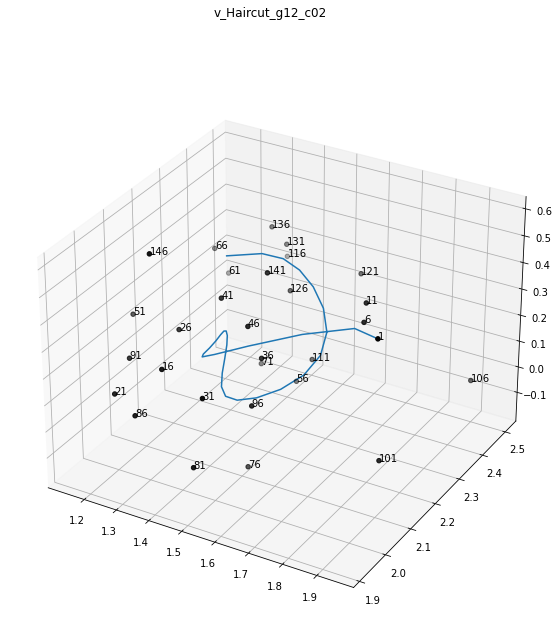

10 2375 v_BodyWeightSquats_g15_c03


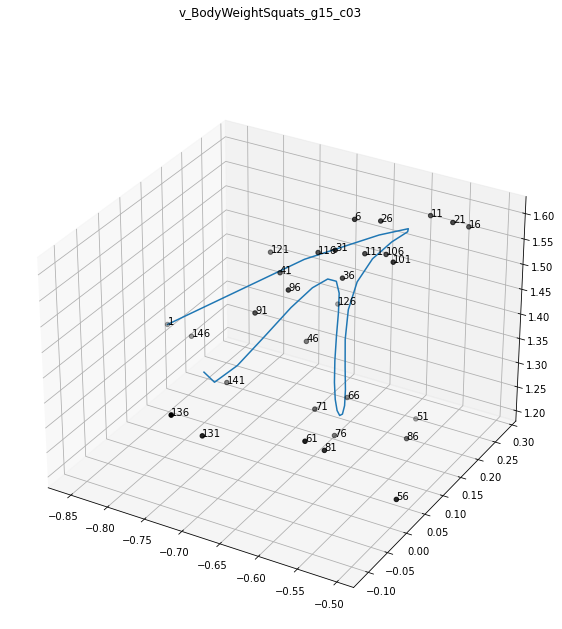

In [45]:
for i in range(len(curves)):
#     print(i, len(curves), video_names[i])
    if video_names[i] in ['v_BodyWeightSquats_g15_c03', 'v_Haircut_g12_c02']:
        print(i, len(curves), video_names[i])
        plot_bezier(curves[i], video_names[i])


# Curvature plot

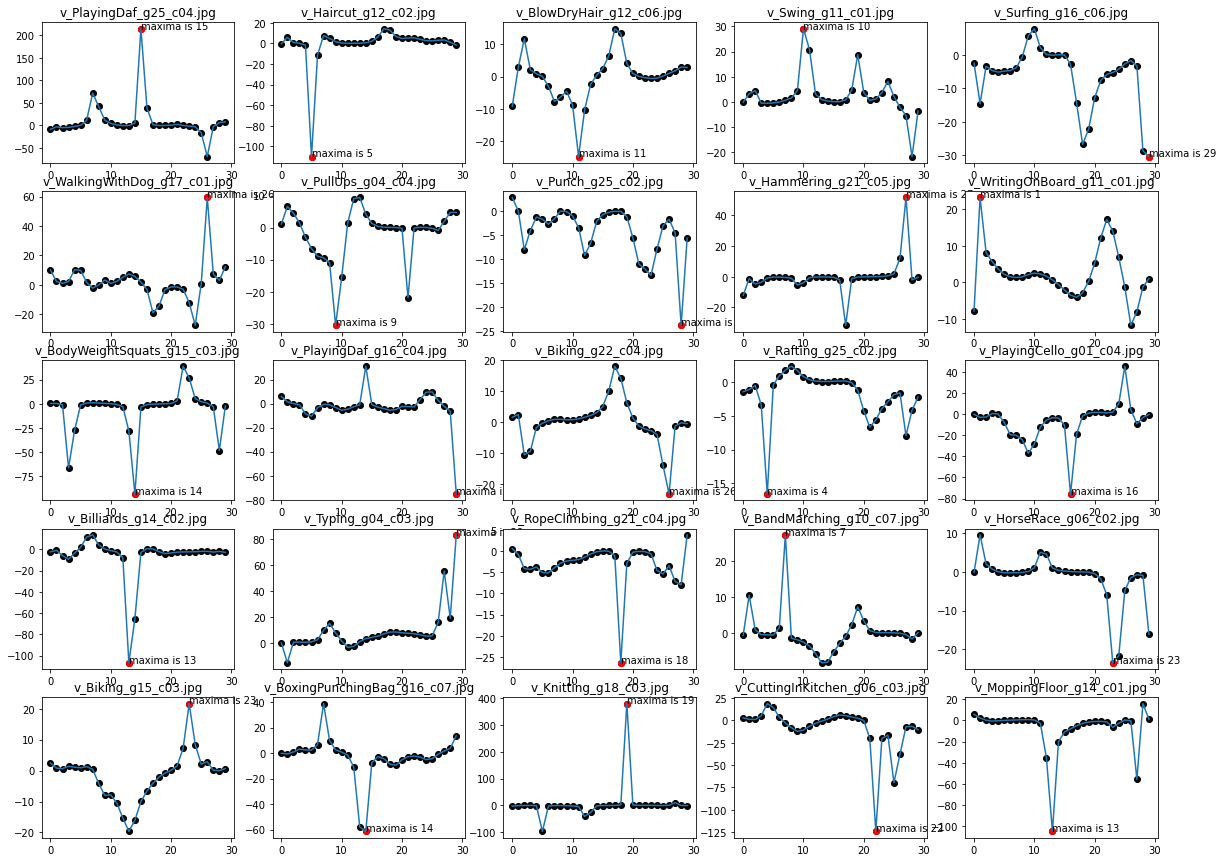

In [18]:
rows = 5
cols = 5

fig, axes = plt.subplots(rows, cols, figsize=(20, 15))

points = dict()

for i in range(rows):
    for j in range(cols):
        if abs(max(k[video_names[cols*i+j]])) - abs(min(k[video_names[cols*i+j]])) < 0:
            point = k[video_names[cols*i+j]].index(min(k[video_names[cols*i+j]]))
        else:
            point = k[video_names[cols*i+j]].index(max(k[video_names[cols*i+j]]))

            
        axes[i][j].plot(k[video_names[cols*i+j]])
        axes[i][j].scatter(range(30), k[video_names[cols*i+j]], color='black')
        axes[i][j].scatter(point, k[video_names[cols*i+j]][point], color='red')
        axes[i][j].text(point, k[video_names[cols*i+j]][point], 'maxima is {}'.format(point))
        axes[i][j].set_title('{}.jpg'.format(video_names[cols*i+j]))
        points[video_names[cols*i+j]] = point
        
# plt.savefig('./plot/curvature/5x5.jpeg')
plt.show()
# plt.close()

In [ ]:
v_Hammering_g21_c05

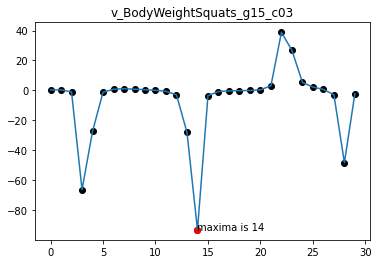

In [29]:
## 움직임이 있는 비디오 예시 ##
import matplotlib.pyplot as plt
if 'v_BodyWeightSquats_g15_c03' in video_names:
        video_name = 'v_BodyWeightSquats_g15_c03'
        if abs(max(k[video_name])) - abs(min(k[video_name])) < 0:
            point = k[video_name].index(min(k[video_name]))
        else:
            point = k[video_name].index(max(k[video_name]))
            
            
        
        plt.title(video_name)
        plt.plot(k[video_name])
        plt.scatter(range(30), k[video_name], color='black')
        plt.scatter(point, k[video_name][point], color='red')
        plt.text(point, k[video_name][point], 'maxima is {}'.format(point))
        plt.savefig('BodyWeightSquats.jpeg')
        plt.show()
        plt.close()

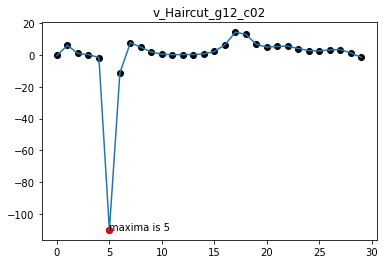

In [30]:
## 움직임이 크게 없는 예시 ##
# 5번의 경우 사람 얼굴이 돌아가는 것 때메 그럴 수 있음
import matplotlib.pyplot as plt
if 'v_Haircut_g12_c02' in video_names:
        video_name = 'v_Haircut_g12_c02'
        if abs(max(k[video_name])) - abs(min(k[video_name])) < 0:
            point = k[video_name].index(min(k[video_name]))
        else:
            point = k[video_name].index(max(k[video_name]))
            
            
        
        plt.title(video_name)
        plt.plot(k[video_name])
        plt.scatter(range(30), k[video_name], color='black')
        plt.scatter(point, k[video_name][point], color='red')
        plt.text(point, k[video_name][point], 'maxima is {}'.format(point))
        plt.savefig('Haircut.jpeg')
        plt.show()
        plt.close()

# Video Images

In [12]:
# import natsort
dir_path='./ucf_image'

for index in range(len(video_names)):
    print("{}/{}: {}".format(index+1, len(video_names), video_names[index]))

    video_paths = [os.path.join(dir_path, video_name) for video_name in video_names]
    video = os.listdir(video_paths[index])
    video = natsort.natsorted(video,reverse=False)[::5] # sorting the files
    video_img_path = [os.path.join(video_paths[index], i) for i in video]


    imgs = [plt.imread(video_img_path[i]) for i in range(30)]
    rows = 6
    cols = 5

    plt.tight_layout()
    
    fig, axes = plt.subplots(rows, cols, figsize=(15, 15))

    fig.suptitle('Video name is {}'.format(video_names[index]),fontsize='20')

    for i in range(rows):
        for j in range(cols):
            axes[i][j].imshow(imgs[cols*i+j])
            axes[i][j].set_title('Curvature {:.6f}_{}.jpg'.format( k[video_names[index]][cols*i+j] , cols*i+j  ))
    plt.savefig('./plot/imgs/{}.jpeg'.format(video_names[index]))
#     plt.show()
    plt.close()
    if index == 20: break

1/9812: v_PlayingDaf_g25_c04
2/9812: v_Haircut_g12_c02
3/9812: v_BlowDryHair_g12_c06
4/9812: v_Swing_g11_c01
5/9812: v_Surfing_g16_c06
6/9812: v_WalkingWithDog_g17_c01
7/9812: v_PullUps_g04_c04
8/9812: v_Punch_g25_c02
9/9812: v_Hammering_g21_c05
10/9812: v_WritingOnBoard_g11_c01
11/9812: v_BodyWeightSquats_g15_c03
12/9812: v_PlayingDaf_g16_c04
13/9812: v_Biking_g22_c04
14/9812: v_Rafting_g25_c02
15/9812: v_PlayingCello_g01_c04
16/9812: v_Billiards_g14_c02
17/9812: v_Typing_g04_c03
18/9812: v_RopeClimbing_g21_c04
19/9812: v_BandMarching_g10_c07
20/9812: v_HorseRace_g06_c02
21/9812: v_Biking_g15_c03


<Figure size 432x288 with 0 Axes>

In [173]:
embeddings.shape 

(10, 30, 3)

In [4]:
# #############################
# ### UCF101 dataset sample ###
# #############################

# dir_path = './ucf_image'
# video_imgs_path = os.path.join(os.getcwd(), dir_path)
# folders = os.listdir(video_imgs_path)

# frames = {}
# for folder in folders:
#     path = os.path.join(video_imgs_path, folder)
#     frames[folder] = len(os.listdir(path))
    
# video_names = []



# for video_name, num_of_frames in zip(list(frames.keys()), list(frames.values())):
#     if upper <= num_of_frames and num_of_frames <= lower:
#         video_names.append(video_name)
# print("Select The number of frames between [%d, %d] of UCF101 Dataset" %(upper, lower))
# print('The number of selected videos is', len(video_names))

# video_names = natsort.natsorted(video_names)

# with open("./labels.txt", 'w+') as f:
#         for name in video_names: f.write(name+'\n')
            
            
# with open('labels.txt', 'r') as f:
#     y = f.readlines()

# labels = []
# for label in y:
#     loc1 = label.find('_')
#     loc2 = loc1 + label[loc1+1:].find('_')
#     labels.append(label[loc1+1:loc2+1])
# y, _ = encoder(labels)
# y = torch.tensor(y, dtype=torch.float) # [N(13320, 1)

Select The number of frames between [150, 10000] of UCF101 Dataset
The number of selected videos is 9812


In [21]:
# vgg16 = models.vgg16(pretrained=True)
# net = nn.Sequential(vgg16.features,
#                    nn.AdaptiveAvgPool2d((1,1))).to(device)


# output = []
# X = []
# for i, file in enumerate(video_names[:cut]):
#     print(i+1, len(video_names[:cut]), file)
#     path = os.path.join(dir_path, file)
#     x = jpg2np(path) / 255. # (30, 3, 240, 320)
#     X.append(x)
#     x = torch.from_numpy(x).float().to(device) 
#     y_ = net(x).squeeze().cpu().detach().numpy()
#     output.append(y_)    
#     break
    

1 1000 v_Hammering_g14_c03


In [9]:
# ## Load vgg16 embedding data ##
# embeddings = []
# labels = []
# for embedding in os.listdir('./ucf_embeddings'):
#     if embedding == '.ipynb_checkpoints': continue
#     loc1 = embedding.find('_')
#     loc2 = loc1 + embedding[loc1+1:].find('_')
#     labels.append(embedding[loc1+1:loc2+1])
        
#     embeddings.append(np.load('./ucf_embeddings/{}'.format(embedding)))
    
# y, _ = encoder(labels)

# embeddings = np.stack(embeddings)
# embeddings_pca = embeddings.reshape(embeddings.shape[0]*embeddings.shape[1],-1)


# ## PCA ##
# pca = PCA(3)
# embeddings_pca = pca.fit_transform(embeddings_pca).reshape(embeddings.shape[0], embeddings.shape[1],-1)


# ## Bezier Curve and Curvature ##
# k = dict()
# curves = []
# for i, embedding in enumerate(embeddings_pca):
# #     print(embedding.shape)
#     curves.append(bezier.Curve.from_nodes(embedding.T))
#     kappa = []
#     for s in range(30):
#         t = s / 30
#         tangent_vec = curves[i].evaluate_hodograph(t)
#         kappa.append(get_curvature(embedding.T, tangent_vec, t))
#     k[video_names[i]] = kappa

# K = np.stack(list(k.values())) # [N, 30]


# ## Elementwise operation ##
# result = list()
# for video in range(len(embeddings)):
#     elementwise = list()
#     for frame in range(30):
#         elementwise.append(embeddings[video][frame] * K[video][frame])        
#     result.append(np.stack(elementwise))
#     if (video+1) % 100 == 0: 
#         print("[%d / %d] video processing!" %(video, len(embeddings)))
# result = torch.from_numpy(np.stack(result))


In [59]:
# from model import UCF_DNN, UCF_CNN1D, UCF_CNN2D
# from sklearn.model_selection import train_test_split


# if datastyle =='embeddings':
#     X = torch.from_numpy(embeddings)
# if datastyle == 'elementwise':
#     X = result
# Y = y[:cut]
# ## train / test split ##
# x_train, x_test, y_train, y_test = train_test_split(X, Y, train_size=0.8, shuffle=True, random_state=123)
# train_dataset = TensorDataset(x_train, y_train)
# train_loader = DataLoader(train_dataset, batch_size=bs, shuffle=True)
# test_dataset = TensorDataset(x_test, y_test)
# test_loader = DataLoader(test_dataset, batch_size=bs)
# print(X.shape, Y.shape)




# num_of_classes = 101

# h_in, h_out =  X.shape[1]*X.shape[2], num_of_classes # UCF101
# h1, h2, h3, h4, h5 = 512, 256, 128, 128, 100 

# model = UCF_DNN(h_in, h1, h2, h3, h4, h5, h_out).to(device)

# criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), lr=0.0001,  weight_decay=1e-5)


# epochs=10
# model.train()
# for epoch in range(epochs):
#     bs_step = 0
#     correct = 0
#     for x, y in train_loader: 

#         x, y_true = x.to(device), y.squeeze().long().to(device)
#         optimizer.zero_grad()

#         y_pred = model(x)
#         _, predicted = torch.max(y_pred, 1)
    
#         loss = criterion(y_pred, y_true)
#         loss.backward()
    
#         optimizer.step()
#         bs_step += bs
#         correct += (predicted == y_true).sum().item()


#     train_acc = 100 * correct / bs_step

#     print("Epoch {}/{} | Loss {:.4f} | Accuracy {:2.2f}".format(
#             epoch, epochs, loss.item(), train_acc))
    
    

# # Test the model
# model.eval()
# with torch.no_grad():
#     correct = 0
#     total = 0

#     for x, y in test_loader:
#         x, labels = x.to(device), y.squeeze().long().to(device)

#         y_pred = model(x)
#         _, predicted = torch.max(y_pred, 1)
#         total += labels.shape[0]
#         correct += (predicted == labels).sum().item()

# test_acc = 100 * correct / total
# print("\n\n\n  The test accuracy {:2.2f}%".format(test_acc))

(torch.Size([6454, 30, 512]), (6454, 30, 512))

In [10]:
# from sklearn.decomposition import PCA
# import bezier

# pca = PCA(3)
# embeddings_pca = [pca.fit_transform(output[i]) for i in range(cut)]
# embeddings_pca = np.stack(embeddings_pca)



# k = dict()
# curves = []
# for i, embedding in enumerate(embeddings_pca):
# #     print(embedding.shape)
#     curves.append(bezier.Curve.from_nodes(embedding.T))
#     kappa = []
#     for s in range(30):
#         t = s / 30
#         tangent_vec = curves[i].evaluate_hodograph(t)
#         kappa.append(get_curvature(embedding.T, tangent_vec, t))
#     k[video_names[i]] = kappa

# """
# N개의 video에는 30개의 Frames가 있고
# 이를 Embedding -> PCA -> Bezier Curve Approximation하면
# 그 Frame의 수에 따라 일정한 비율로 30개의 Curvautre를 구함
# """
# K = np.stack(list(k.values())) # [N, 30]
# print(K.shape) # [N, 30]

In [11]:
# embeddings = torch.from_numpy(np.stack(output))

# result = list()

# for video in range(len(embeddings)):
#     elementwise = list()
#     for frame in range(30):
# #         print((embeddings[video][frame][:] * K[video][frame]))
#         elementwise.append(embeddings[video][frame] * K[video][frame])        
#     result.append(np.stack(elementwise))
#     if (video+1) % 100 == 0: 
#         print("[%d / %d] video processing!" %(video, len(embeddings)))
# result = torch.from_numpy(np.stack(result))
# print(result.shape) # [N, 30, 512]

# Task1.Action Recognition

In [12]:
# from sklearn.model_selection import train_test_split
# if datastyle =='embeddings':
#     X = torch.from_numpy(np.stack(output))
# if datastyle == 'elementwise':
#     X = result
# Y = y[:cut]
# ## train / test split ##
# x_train, x_test, y_train, y_test = train_test_split(X, Y, train_size=0.8, shuffle=True, random_state=123)
# train_dataset = TensorDataset(x_train, y_train)
# train_loader = DataLoader(train_dataset, batch_size=bs, shuffle=True)
# test_dataset = TensorDataset(x_test, y_test)
# test_loader = DataLoader(test_dataset, batch_size=bs)
# print(X.shape, Y.shape)

# UCF_DNN

In [13]:
# from model import UCF_DNN, UCF_CNN1D, UCF_CNN2D

# num_of_classes = 101
# h_in, h_out =  X.shape[1]*X.shape[2], num_of_classes # UCF101
# h1, h2, h3, h4, h5 = 512, 256, 128, 128, 100 
# model = UCF_DNN(h_in, h1, h2, h3, h4, h5, h_out).to(device)


# criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), lr=0.0001,  weight_decay=1e-5)


# epochs=100
# model.train()
# for epoch in range(epochs):
#     bs_step = 0
#     correct = 0
#     for x, y in train_loader: 

#         x, y_true = x.to(device), y.squeeze().long().to(device)
#         optimizer.zero_grad()

#         y_pred = model(x)
#         _, predicted = torch.max(y_pred, 1)
    
#         loss = criterion(y_pred, y_true)
#         loss.backward()
    
#         optimizer.step()
#         bs_step += bs
#         correct += (predicted == y_true).sum().item()


#     train_acc = 100 * correct / bs_step

#     print("Epoch {}/{} | Loss {:.4f} | Accuracy {:2.2f}".format(
#             epoch, epochs, loss.item(), train_acc))
    
    

# # Test the model
# model.eval()
# with torch.no_grad():
#     correct = 0
#     total = 0

#     for x, y in test_loader:
#         x, labels = x.to(device), y.squeeze().long().to(device)

#         y_pred = model(x)
#         _, predicted = torch.max(y_pred, 1)
#         total += labels.shape[0]
#         correct += (predicted == labels).sum().item()

# test_acc = 100 * correct / total
# print("\n\n\n  The test accuracy {:2.2f}%".format(test_acc))

# UCF 1D CNN

In [14]:
# # from model import UCF_DNN, UCF_CNN1D, UCF_CNN2D

# num_of_classes = 101
# # torch.Size([100, 30, 512]) torch.Size([100, 1])
# ## UCF_CNN1D ##
# h_in, h_out = 30, num_of_classes # UCF101
# h1, h2, h3, h4, h5 = 256, 128, 64, 1000, 500
# model = UCF_CNN1D(h_in, h1, h2, h3, h4, h5, h_out).to(device)



# criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), lr=0.0001,  weight_decay=1e-5)

# # model(X.to(device))

# epochs=100
# model.train()
# for epoch in range(epochs):
#     bs_step = 0
#     correct = 0

#     for x, y in train_loader: 

#         x, y_true = x.to(device), y.squeeze().long().to(device)
#         optimizer.zero_grad()

#         y_pred = model(x)

#         _, predicted = torch.max(y_pred, 1)
    
#         loss = criterion(y_pred, y_true)
#         loss.backward()
    
#         optimizer.step()
#         bs_step += bs
#         correct += (predicted == y_true).sum().item()


#     train_acc = 100 * correct / bs_step

#     print("Epoch {}/{} | Loss {:.4f} | Accuracy {:2.2f}".format(
#             epoch, epochs, loss.item(), train_acc))
    
    

# # Test the model
# model.eval()
# with torch.no_grad():
#     correct = 0
#     total = 0

#     for x, y in test_loader:
#         x, labels = x.to(device), y.squeeze().long().to(device)

#         y_pred = model(x)
#         _, predicted = torch.max(y_pred, 1)
#         total += labels.shape[0]
#         correct += (predicted == labels).sum().item()

# test_acc = 100 * correct / total
# print("\n\n\n  The test accuracy {:2.2f}%".format(test_acc))

# UCF 2D CNN

In [15]:
# from model import UCF_DNN, UCF_CNN1D, UCF_CNN2D

# num_of_classes = 101
# # torch.Size([100, 30, 512]) torch.Size([100, 1])
# ## UCF_CNN2D ##
# h_in, h_out = 30, num_of_classes # UCF101
# h1, h2, h3, h4, h5 = 256, 128, 64, 1000, 500
# model = UCF_CNN2D(h_in, h1, h2, h3, h4, h5, h_out).to(device)



# criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), lr=0.0001,  weight_decay=1e-5)

# # model(X.to(device))

# epochs=100
# model.train()
# for epoch in range(epochs):
#     bs_step = 0
#     correct = 0

#     for x, y in train_loader: 

#         x, y_true = x.to(device), y.squeeze().long().to(device)
#         optimizer.zero_grad()

#         y_pred = model(x)

#         _, predicted = torch.max(y_pred, 1)
    
#         loss = criterion(y_pred, y_true)
#         loss.backward()
    
#         optimizer.step()
#         bs_step += bs
#         correct += (predicted == y_true).sum().item()


#     train_acc = 100 * correct / bs_step

#     print("Epoch {}/{} | Loss {:.4f} | Accuracy {:2.2f}".format(
#             epoch, epochs, loss.item(), train_acc))
    
    

# # Test the model
# model.eval()
# with torch.no_grad():
#     correct = 0
#     total = 0

#     for x, y in test_loader:
#         x, labels = x.to(device), y.squeeze().long().to(device)

#         y_pred = model(x)
#         _, predicted = torch.max(y_pred, 1)
#         total += labels.shape[0]
#         correct += (predicted == labels).sum().item()

# test_acc = 100 * correct / total
# print("\n\n\n  The test accuracy {:2.2f}%".format(test_acc))

# Calculate the Curvature 

In [40]:
# from sklearn.decomposition import PCA
# pca = PCA(3)
# embeddings = [pca.fit_transform(output[i]) for i in range(cut)]
# embeddings = np.stack(embeddings)


# import bezier
# k = dict()
# curves = []
# for i, embedding in enumerate(embeddings):
# #     print(embedding.shape)
#     curves.append(bezier.Curve.from_nodes(embedding.T))
#     kappa = []
#     for s in range(30):
#         t = s / 30
#         tangent_vec = curves[i].evaluate_hodograph(t)
#         kappa.append(get_curvature(embedding.T, tangent_vec, t))
#     k[video_names[i]] = kappa

# """
# N개의 video에는 30개의 Frames가 있고
# 이를 Embedding -> PCA -> Bezier Curve Approximation하면
# 그 Frame의 수에 따라 일정한 비율로 30개의 Curvautre를 구함
# """
# K = np.stack(list(k.values())) # [N, 30]

In [ ]:
# embeddings = X

# result = list()

# for video in range(len(embeddings)):
#     elementwise = list()
#     for frame in range(30):
# #         print((embeddings[video][frame][:] * K[video][frame]))
#         elementwise.append(embeddings[video][frame] * K[video][frame])        
#     result.append(np.stack(elementwise))
#     if (video+1) % 100 == 0: 
#         print("[%d / %d] video processing!" %(video, len(embeddings)))
# result = np.stack(result)        
# result.shape